In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random


## Data Pre-processing

* converted all words into lower case for uniformity
* Removed neutral reviews to only focus on positive and negative reviews




In [2]:
df = pd.read_csv('../input/twitter-airline-sentiment/Tweets.csv', usecols=['text', 'airline_sentiment'])
df['text'] = df['text'].str.lower()
df = df[df['airline_sentiment'] != 'neutral']
df['airline_sentiment'] = df['airline_sentiment'].str.replace('positive', '1')
df['airline_sentiment'] = df['airline_sentiment'].str.replace('negative', '0')

**Splitting the dataset into train/validation/test sets at a 60:20:20 ratio **

In [3]:
train, validate, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [4]:
train_sentences = train['text'].values
train_labels = train['airline_sentiment'].values

validation_sentences = validate['text'].values
validation_labels = validate['airline_sentiment'].values

test_sentences = test['text'].values
test_labels = test['airline_sentiment'].values



**Hyperparameters**

In [5]:
embedding_dim = 100
max_length = 16
padding_type='post'
trunc_type = 'post'
oov_tok = '<OOV>'

In [6]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index)

sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## Using Stanford's Glove to Create an Embedding Matrix

The dataset used for this project is small and consequently has a small number of words, which can lead to overfitting. Embeddings derived from this dataset can be overgeneralized so I decided to use transfer learning and import Stanford's Glove to use a pre-trained set of embeddings to help improve model performance.

In [7]:
embeddings_index = {}
with open("../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 10
history = model.fit(padded, train_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=1)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 100)           994100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 100)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16, 128)           84480     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                30912     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,110,549
Trainable params: 116,449
Non-trainable params: 994,100
________________________________________

In [15]:
test_accuracy = model.evaluate(testing_padded, test_labels)
print('Test accuracy of model is : {0:.2f}%'.format(test_accuracy[1]*100))

2309/2309 [==============================] - 1s 292us/sample - loss: 0.2481 - acc: 0.9104
Test accuracy of model is : 91.04%


<Figure size 432x288 with 0 Axes>

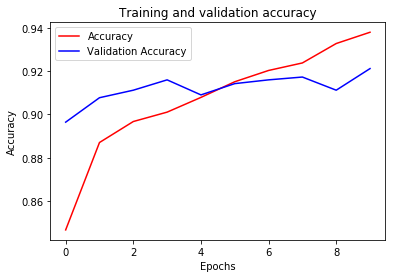

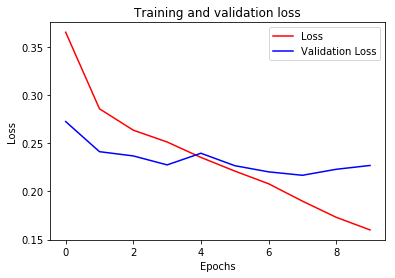

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(num_epochs) # Get number of epochs

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
